In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('stylesheet.mplstyle')

# Set color variables to make colors easier later
lightblue = '#54d2d2'
yellow = '#ffcb00'
orange = '#f8aa4b'
pink = '#ff6150'
gray = '#a89cac'
wrblue = '#0197F6'

# define some dictionaries to make it easy to loop over metallicities
cc = {'Z014': pink,
      'Z006': orange,
      'Z002': yellow,
      'Z0002': lightblue}

zdict = {'Z014': 0.014,
         'Z006': 0.006,
         'Z002': 0.002,
         'Z0002': 0.0002}

wrdict = {'Z014': 7.5,
          'Z006': 11,
          'Z002': 17}

dropdict = {'Z006': [27.8, 6, 4.9],
            'Z002': [8.6, 1.9, 1.5],
            'Z0002': [5.8, 1.3, 1.0]}

In [ ]:
# array of orders of magnitude that we will be plotting
oom = np.geomspace(1e-1, 1e4, 6)
# bins
bins = np.geomspace(1, 50, 1000)
# arrays in which to store calculated data and 1 stdev
contours = np.zeros([len(cc), len(oom)])
contour_sigma = np.zeros([len(cc), len(oom)])

# loop over metallicities
for l, env in enumerate(cc.keys()):
    datafile = f'../data/histograms/hist_{env}.txt'
    hists = np.genfromtxt(datafile)
    # make a cdf that's calculated from 50 Msun to 1 Msun
    cdf = np.flip(np.cumsum(np.flip(hists, axis=1), axis=1), axis=1)
    
    where_arr = np.zeros([len(cdf), len(oom)])
    for i, row in enumerate(cdf):
        for j, oo in enumerate(oom):
            # figure out the first index where there is at least 1eX star
            # and index into that mass
            where_arr[i][j] = bins[np.where(row > oo)[0][-1]]

    contours[l] = np.mean(where_arr, axis=0)
    contour_sigma[l] = np.std(where_arr, axis=0)

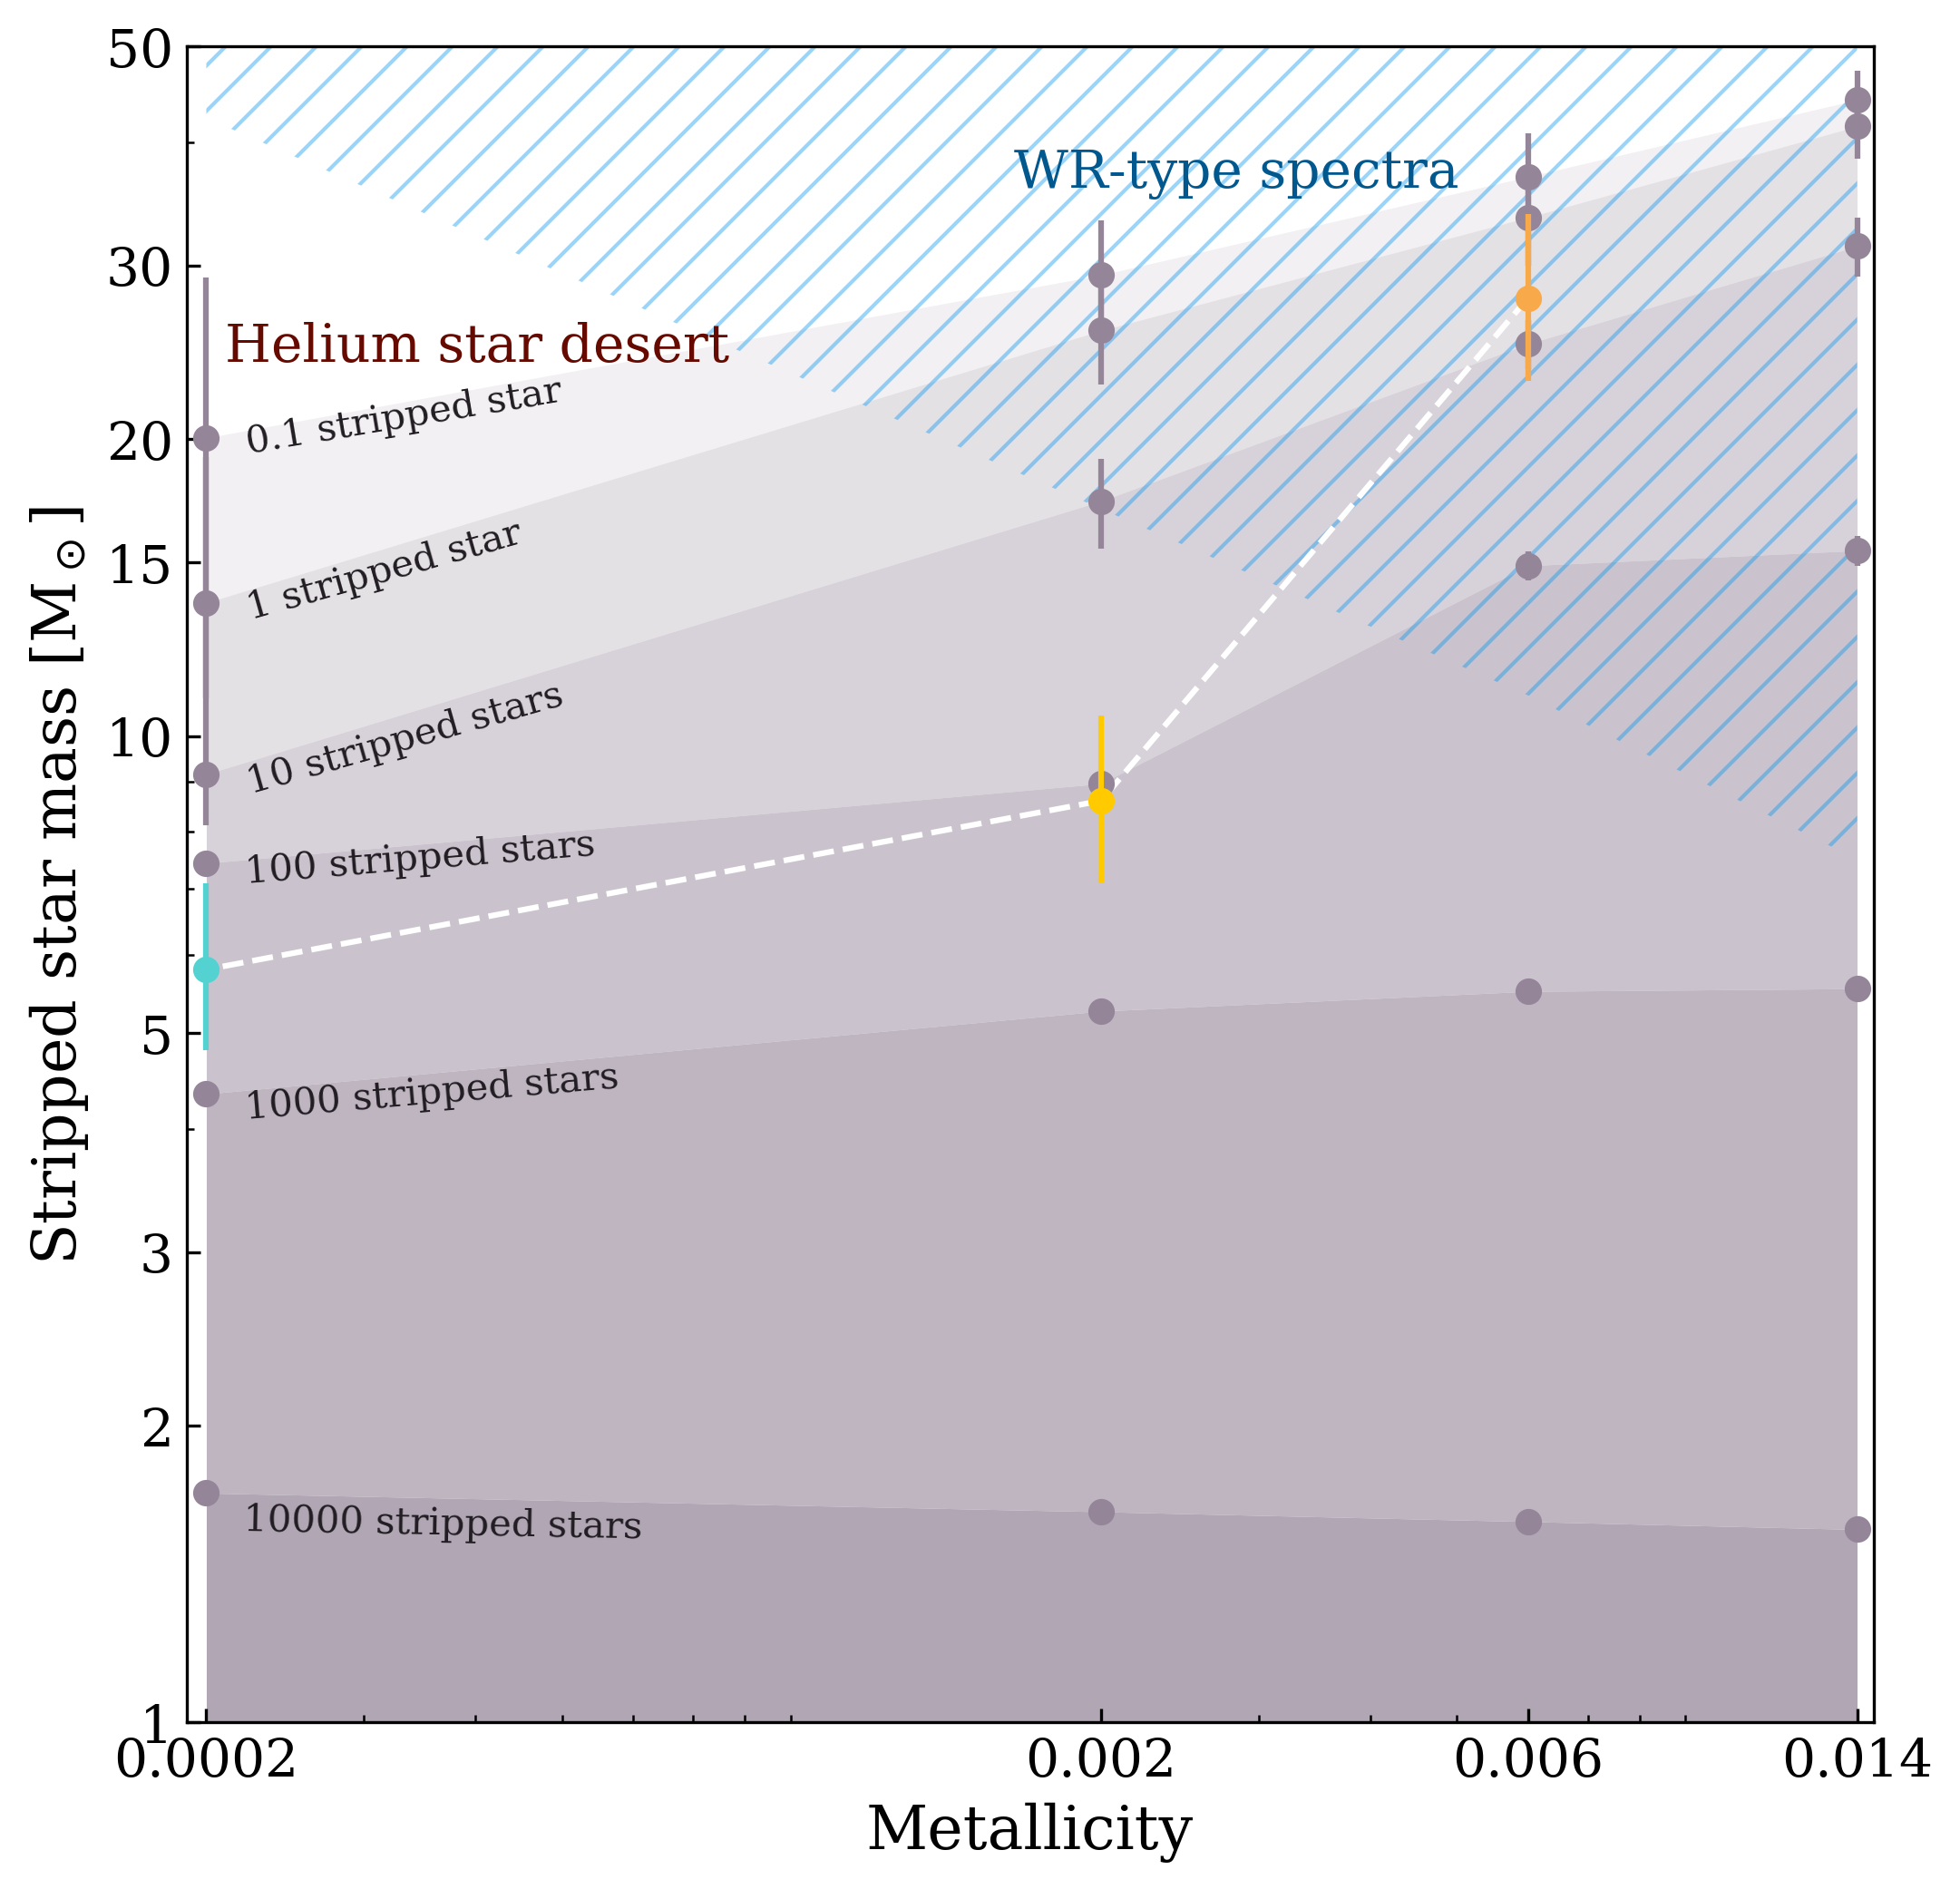

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for i, masses in enumerate(contours.T):
    if i>len(contours.T)-7:
        # plot contour with errorbar
        ax.errorbar(zdict.values(), masses, yerr=contour_sigma.T[i], c='#948599', fmt='o', zorder=100)
        # label the contour with the order of magnitude
        label = f'{oom[i]:.0f} stripped stars'
        if i < 5:
            masses_last = contours.T[i+1]
        else:
            masses_last = [1,1,1,1]
        if i<2:
            label = label.rstrip('s')
        if i==0:
            label = f'{oom[i]:.1f} stripped star'
        slope = np.log10(masses[-2]/masses[-1])/np.log10(0.002/0.0002)*180/np.pi
        textheight = masses[-1] / 1.03 - 0.12
        ax.fill_between(zdict.values(), masses_last, masses, color=gray, alpha=0.15*(i+1), linewidth=0)
        ax.text(0.00022, textheight, label, color='#201C22', rotation=slope, size=10)
    
# Fill in the regime where stripped stars should have WR-type spectra in blue hatching
# Fill between LMC and MW
coeff = np.polyfit(np.log10([0.014, 0.006]), np.log10(list(wrdict.values())[:2]), 1)
fit = 10**np.polyval(coeff, np.log10([0.014, 0.006]))
ax.fill_between([0.014, 0.006], fit, [50, 50], color='none', edgecolor=wrblue, alpha=0.4, linewidth=0, hatch='//')
# Fill between SMC and LMC, extrapolating out to iZw18
coeff = np.polyfit(np.log10([0.002, 0.006]), np.log10(list(wrdict.values())[:0:-1]), 1)
fit = 10**np.polyval(coeff, np.log10([0.0002, 0.002, 0.006]))
ax.fill_between([0.002, 0.006], fit[1:], [50, 50], color='none', edgecolor=wrblue, 
                alpha=0.4, linewidth=0, hatch='//')
ax.fill_between([0.0002, 0.002], fit[:-1], [50, 50], color='none', edgecolor=wrblue, 
                alpha=0.4, linewidth=0, hatch='//')
ax.text(0.0016, 36, 'WR-type spectra', c='#01588E', size=14)

# Label the helium star desert
ax.text(0.00021, 24, 'Helium star desert', color='#660A00', size=14)

# Plot the drop determined from figure 4
for env in list(cc.keys())[1:]:
    y, y_err_upper, y_err_lower = dropdict[env]
    ax.errorbar([zdict[env]], [y], yerr=[[y_err_lower], [y_err_upper]], fmt='o', c=cc[env], zorder=1000)
plt.plot(list(zdict.values())[1:], np.array(list(dropdict.values()))[:,0], c='white', ls='--')

# axis formatting
ax.set_xscale('log')
ax.set_xlabel('Metallicity')
ax.set_xlim(0.00019, 0.0146)
ax.set_xticks([0.0002, 0.002, 0.006, 0.014])
ax.set_xticklabels(['0.0002', '0.002', '0.006', '0.014'])

ax.set_yscale('log')
ax.set_ylabel(r'Stripped star mass [M$_\odot$]')
ax.set_ylim(1, 50)
ax.set_yticks([1, 2, 3, 5, 10, 15, 20, 30, 50])
ax.set_yticklabels(['1', '2', '3', '5', '10', '15', '20', '30', '50'])

plt.savefig('contour.png', bbox_inches='tight')